# Autocorrelation and autocovariance

Look at the speech signal segment below. On a large scale it is
hard to discern a structure, but on a small scale, the signal seems
continuous. Speech signals typically have such structure that samples
near in time to each other are similar in amplitude. Such structure is
often called short-term temporal structure.

More specifically, samples of the signal are *correlated* with the
preceding and following samples. Such structures are in statistics
measured by covariance and correlation, defined for zero-mean variables
x and y as

$$ \begin{split} \text{covariance: } & \sigma_{xy} = E[xy] \\
\text{correlation: } & \rho_{xy} =
\frac{E[xy]}{\sqrt{E[x^2]E[y^2]}}, \end{split} $$

where $E[ \cdot ]$ is the expectation operator.

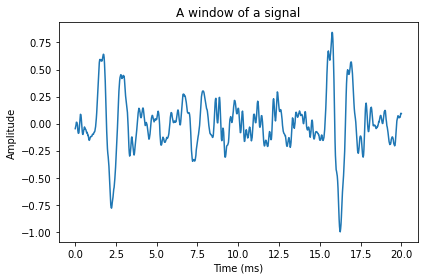

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy


# read from storage
filename = 'sounds/test.wav'
fs, data = wavfile.read(filename)

window_length_ms = 20
window_length = int(np.round(fs*window_length_ms/1000))

n = np.linspace(0.5,window_length-0.5,num=window_length)

#windowpos = np.random.randint(int((len(data)-window_length)))
windowpos = 92274

datawin = data[windowpos:(windowpos+window_length)]
datawin = datawin/np.max(np.abs(datawin)) # normalize

plt.plot(n*1000/fs,datawin)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('A window of a signal')
plt.tight_layout()
plt.show()


For a speech signal $x_{n}$, where $n$ is the time-index, we
would like to measure the correlation between two
time-indices $x_{n}$ and $x_{h}$. Since the structure
which we are interested in appears when $n$ and $h$ are near each other,
it is better to measure the correlation
between $x_{n}$ and $x_{n-k}$. The scalar $k$ is known
as the *lag*. Furthermore, we can assume that the correlation is uniform
over all $n$ within the segment. The self-correlation and -covariances,
known as the *autocorrelation* and *autocovariance* are defined as

$$ \begin{split} \text{autocovariance: } & r_{k} =
E_n[x_nx_{n-k}] \\ \text{autocorrelation: } & c_{k} =
\frac{E_n[x_nx_{n-k}]}{E_n[x_n^2]} = \frac{r_k}{r_0}.
\end{split} $$

The figure below illustrates the autocovariance of the above
speech signal. We can immediately see that the short-time correlations
are preserved - on a small scale, the autocovariance looks similar to
the original speech signal. The oscillating structure is also accurately
preserved. 

Because we assume that the signal is stationary, and as a consequence of
the above formulations, we can readily see that autocovarinaces and
-correlations are symmetric

$$ r_k = E_n[x_nx_{n-k}] = E_n[x_{n+k}x_{n+k-k}] =
E_n[x_{n+k}x_{n}] = r_{-k}. $$

This symmetry is clearly visible in the figure below, where the
curve is mirrored around lag 0.

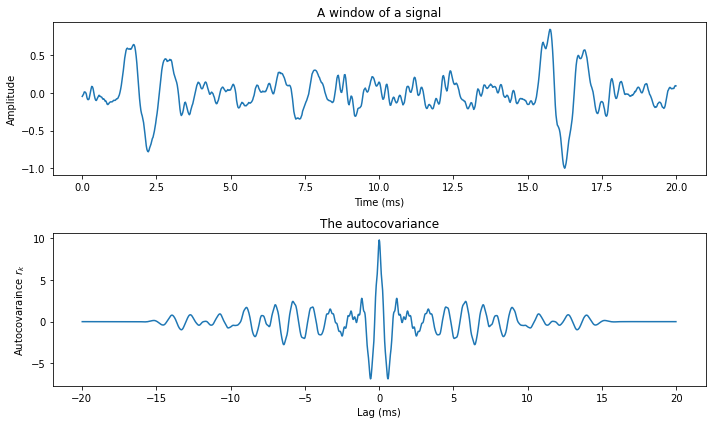

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import scipy.fft


# read from storage
filename = 'sounds/test.wav'
fs, data = wavfile.read(filename)

window_length_ms = 20
window_length = int(np.round(fs*window_length_ms/1000))

n = np.linspace(0.5,window_length-0.5,num=window_length)
n2 = np.linspace(1-window_length,window_length-1,num=window_length*2)

# windowing function
windowing_fn = np.sin(np.pi*n/window_length)**2 # sine-window


#windowpos = np.random.randint(int((len(data)-window_length)))
windowpos = 92274

datawin = data[windowpos:(windowpos+window_length)]
datawin = datawin/np.max(np.abs(datawin)) # normalize

spectrum = scipy.fft.rfft(datawin*windowing_fn,n=2*window_length)
autocovariance = scipy.fft.irfft(np.abs(spectrum**2))
autocovariance = np.concatenate((autocovariance[window_length:],autocovariance[0:window_length]))

plt.figure(figsize=[10,6])
plt.subplot(211)
plt.plot(n*1000/fs,datawin)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('A window of a signal')
plt.subplot(212)
plt.plot(n2*1000/fs,autocovariance)
plt.xlabel('Lag (ms)')
plt.ylabel('Autocovaraince $r_k$')
plt.title('The autocovariance')
plt.tight_layout()
plt.show()



The above formulas use the expectation operator $E[\cdot ]$ to define the
autocovariance and -correlation. It is an abstract tool, which needs to
be replaced by a proper estimator for practical implementations.
Specifically, to estimate the autocovariance from a segment of length
$N$, we use

$$ r_k \approx \frac1{N-1} \sum_{k=1}^{N-1} x_n x_{n-k}. $$

Observe that the speech signal $x_{n}$ has to be
[windowed](Windowing) before using the above formula.

We can also make an on-line estimate (a.k.a. leaky integrator) of the autocovariance for sample
position $n$ with lag $k$ as

$$ \hat r_k(n) := \alpha x_n x_{n-k} + (1-\alpha) \hat r_k(n-1),
$$

where $\alpha\in[0,1]$ is a small positive constant which determines how rapidly the
estimate converges.

It is often easier to work with vector notation instead of scalars,
whereby we need the corresponding definitions for autocovariances.
Suppose

$$ x =
\begin{bmatrix}x_0\\x_1\\\vdots\\x_{N-1}\end{bmatrix}. $$

We can then define the autocovariance matrix as

$$ R_x := E[x x^T] = \begin{bmatrix}E[x_0^2] & E[x_0x_1] &
\dots & E[x_0x_{N-1}]\\E[x_1x_0] & E[x_1^2] & \dots &
E[x_1x_{N-1}]\\\vdots&\vdots&\ddots&\vdots\\E[x_{N-1}x_0]
& E[x_{N-1}x_1] & \dots & E[x_{N-1}^2]\end{bmatrix} =
\begin{bmatrix}r_0 & r_1 & \dots & r_{N-1}\\ r_1 & r_0 & \dots &
r_{N-2}\\\vdots&\vdots&\ddots&\vdots\\r_{N-1} & r_{N-1} &
\dots & r_0\end{bmatrix}. $$

Clearly $R_{x}$ is thus a symmetric
[Toeplitz](https://en.wikipedia.org/wiki/Toeplitz_matrix) matrix.
Moreover, since it is a product of $x$ with itself, $R_{x}$ is
also [positive
(semi-)definite](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix).